
📌 Correlation with Target:
Neighborhood                       0.676907
X4 number of convenience stores    0.571005
X5 latitude                        0.546307
X6 longitude                       0.523287
NearMRT                            0.462278
X1 transaction date                0.087491
Year                               0.081545
X2 house age                      -0.210567
Log_Distance                      -0.734674
Name: Target, dtype: float64

🔻 Dropped (weak corr): ['Month']
🔻 Dropped (high corr): ['QualityIndex', 'X3 distance to the nearest MRT station']


D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


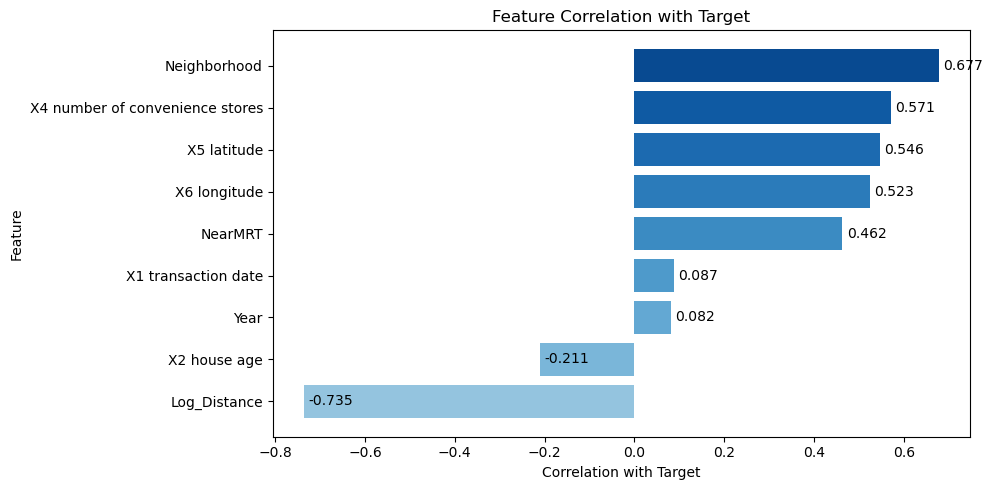

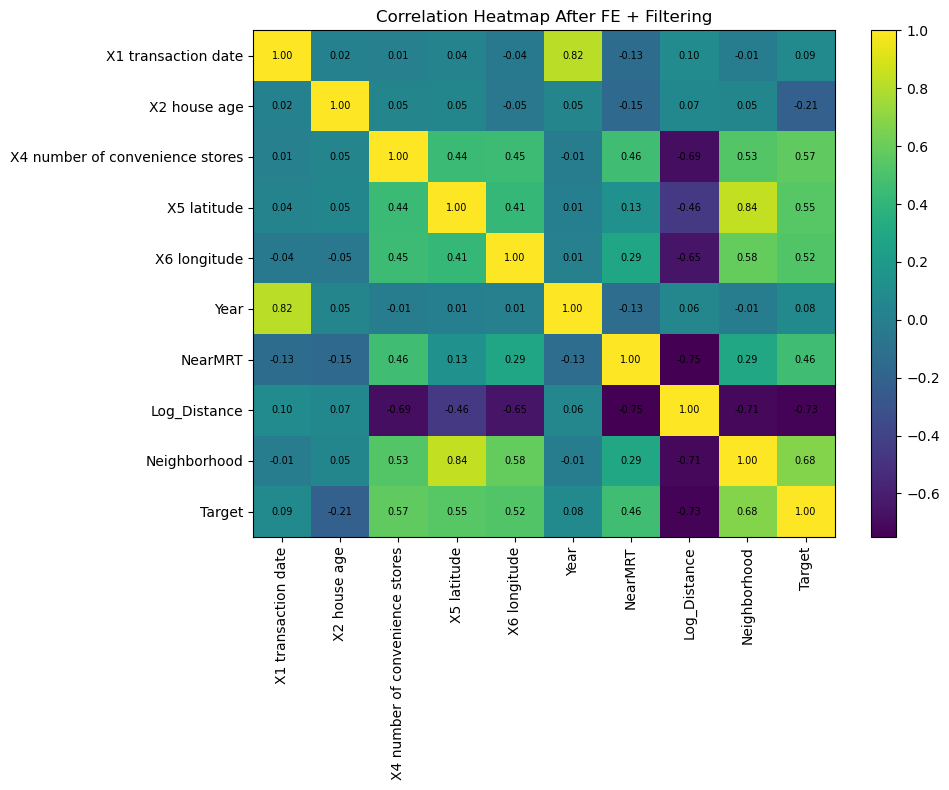


📁 Saved file:
 - filtered_real_estate.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import sys

# ==========================================================
#  الدالة الرئيسية مع Feature Engineering + Correlation Filtering
# ==========================================================

def prune_features_by_correlation_FE(df, target_series,
                                     weak_thresh=(-0.05, 0.05),
                                     high_corr_thresh=0.85,
                                     apply_FE=True):

    df = df.copy().reset_index(drop=True)
    target_series = target_series.reset_index(drop=True)
    target_name = target_series.name if target_series.name else "Target"
    df[target_name] = target_series

    # ----------------------------------------------------
    # FEATURE ENGINEERING مثل مثال Real Estate
    # ----------------------------------------------------
    if apply_FE:

        # 1) حذف العمود غير المفيد No
        if "No" in df.columns:
            df = df.drop(columns=["No"])

        # 2) استخراج السنة والشهر من transaction date
        if "X1 transaction date" in df.columns:
            df["Year"] = df["X1 transaction date"].astype(int)
            df["Month"] = ((df["X1 transaction date"] % 1) * 12).round().astype(int)

        # 3) NearMRT = 1 / distance
        if "X3 distance to the nearest MRT station" in df.columns:
            dist = df["X3 distance to the nearest MRT station"]
            df["NearMRT"] = 1 / (dist + 1)

            # 4) Log distance
            df["Log_Distance"] = np.log1p(dist)

        # 5) Quality Index = convenience / distance
        if ("X4 number of convenience stores" in df.columns) and \
           ("X3 distance to the nearest MRT station" in df.columns):

            df["QualityIndex"] = df["X4 number of convenience stores"] / \
                                 (df["X3 distance to the nearest MRT station"] + 1)

        # 6) Neighborhood عبر KMeans
        if ("X5 latitude" in df.columns) and ("X6 longitude" in df.columns):
            coords = df[["X5 latitude", "X6 longitude"]]
            kmeans = KMeans(n_clusters=5, random_state=42)
            df["Neighborhood"] = kmeans.fit_predict(coords)

    # ----------------------------------------------------
    #   بعد Feature Engineering نبدأ التصفية بالارتباط
    # ----------------------------------------------------

    corr = df.corr()

    # STEP 1: حذف الميزات ذات الارتباط الضعيف مع الهدف
    low, high = weak_thresh
    weak_features = corr[target_name][(corr[target_name] > low) &
                                      (corr[target_name] < high)].index.tolist()
    weak_features = [f for f in weak_features if f != target_name]

    if weak_features:
        df = df.drop(columns=weak_features)
        corr = df.corr()

    # STEP 2: حذف الميزات ذات الترابط العالي فيما بينها
    features = list(df.columns)
    if target_name in features:
        features.remove(target_name)

    to_drop = set()
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            f1, f2 = features[i], features[j]
            if abs(corr.loc[f1, f2]) >= high_corr_thresh:
                corr_f1 = abs(corr.loc[f1, target_name])
                corr_f2 = abs(corr.loc[f2, target_name])
                if corr_f1 < corr_f2:
                    to_drop.add(f1)
                else:
                    to_drop.add(f2)

    if to_drop:
        df = df.drop(columns=list(to_drop))

    remaining_df = df.drop(columns=[target_name])
    return remaining_df, sorted(list(to_drop)), sorted(weak_features)


# ==========================================================
#                    MAIN
# ==========================================================

# قراءة الملف الأساسي بدون تقسيم
df = pd.read_csv("Real estate.csv")

# فصل الميزات عن الهدف
X = df.drop(columns=['Y house price of unit area'])
y = df['Y house price of unit area']
y.name = "Target"

# تطابق الأطوال
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# تطبيق الدالة على البيانات الكاملة
filtered_df, dropped_corr, dropped_weak = prune_features_by_correlation_FE(
    X,
    y,
    weak_thresh=(-0.05, 0.05),
    high_corr_thresh=0.85,
    apply_FE=True
)

# حساب correlation بعد التصفية
corr_new = filtered_df.assign(Target=y).corr()
feature_target_corr = corr_new["Target"].drop("Target").sort_values(ascending=False)

print("\n==============================")
print("📌 Correlation with Target:")
print("==============================")
print(feature_target_corr)

print("\n🔻 Dropped (weak corr):", dropped_weak)
print("🔻 Dropped (high corr):", dropped_corr)

# ==========================================================
#                  الرسم البياني
# ==========================================================

corr_values = feature_target_corr.sort_values(ascending=True)
plt.figure(figsize=(10, 5))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(corr_values)))
plt.barh(corr_values.index, corr_values.values, color=colors)
plt.xlabel("Correlation with Target")
plt.ylabel("Feature")
plt.title("Feature Correlation with Target")

for i, (feat, val) in enumerate(corr_values.items()):
    plt.text(val + 0.01, i, f"{val:.3f}", va='center')

plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_new, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(np.arange(len(corr_new.columns)), corr_new.columns, rotation=90)
plt.yticks(np.arange(len(corr_new.index)), corr_new.index)

for i in range(len(corr_new)):
    for j in range(len(corr_new)):
        plt.text(j, i, f"{corr_new.iloc[i,j]:.2f}",
                 ha='center', va='center', fontsize=7)

plt.title("Correlation Heatmap After FE + Filtering")
plt.tight_layout()
plt.show()

# ==========================================================
#        حفظ ملف واحد مصفى
# ==========================================================

# دمج الميزات المصفاة مع الهدف في ملف واحد
filtered_full_df = filtered_df.copy()
filtered_full_df["Target"] = y

# حفظ الملف النهائي
filtered_full_df.to_csv("filtered_real_estate.csv", index=False)

print("\n📁 Saved file:")
print(" - filtered_real_estate.csv")


عدد الصفوف قبل التنظيف: 414
عدد الصفوف بعد التنظيف: 303


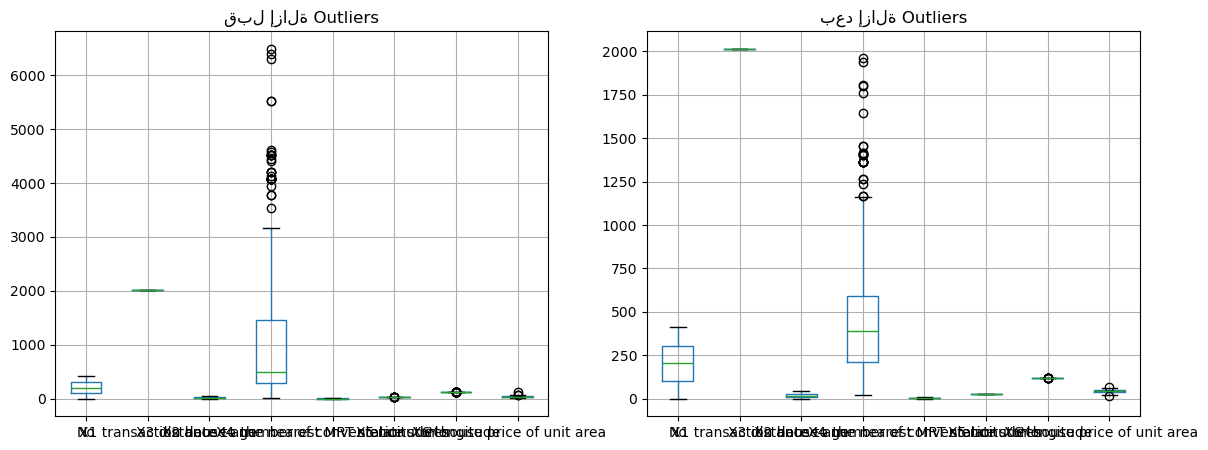


✔ تم حفظ البيانات النظيفة في 'cleaned_real_estate.csv'


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# دالة إزالة Outliers وحدها
# ----------------------------------------
def remove_outliers_and_save(input_file="Real estate.csv", output_file="cleaned_real_estate.csv"):
    # قراءة البيانات
    df = pd.read_csv(input_file)
    
    # دالة إزالة Outliers بطريقة IQR
    def remove_outliers_iqr(data, columns):
        df_clean = data.copy()
        
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        
        return df_clean
    
    # اختيار الأعمدة الرقمية فقط
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    # إزالة الـ outliers
    df_clean = remove_outliers_iqr(df, numeric_cols)
    
    print("عدد الصفوف قبل التنظيف:", len(df))
    print("عدد الصفوف بعد التنظيف:", len(df_clean))
    
    # رسم Boxplot قبل وبعد التنظيف
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    df.boxplot()
    plt.title("قبل إزالة Outliers")
    
    plt.subplot(1,2,2)
    df_clean.boxplot()
    plt.title("بعد إزالة Outliers")
    
    plt.show()
    
    # حفظ البيانات النظيفة
    df_clean.to_csv(output_file, index=False)
    print(f"\n✔ تم حفظ البيانات النظيفة في '{output_file}'")

# ----------------------------------------
# استدعاء الدالة
# ----------------------------------------
remove_outliers_and_save()
